# Lecture 22 – Data 100, Summer 2021

by Suraj Rampure

adapted from John DeNero, Sam Lau, Ani Adhikari

In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tnrange

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## Estimation and Bootstrapping

### Sample Mean Estimator

Let's say our population is finite and we know it: a uniform over the numbers 0 to 10,000 (inclusive). (Note: You would never need statistical inference if you knew the whole population; we're just creating a playground to try out techniques.)

In [2]:
population = np.arange(10001)

In [3]:
population

array([    0,     1,     2, ...,  9998,  9999, 10000])

We might want to know the population mean. In this case, we do!

In [4]:
np.mean(population)

5000.0

But if we only had a sample, then we would perhaps estimate (guess) that the sample mean is a reasonable approximation for the true mean.


In [5]:
sample_100 = np.random.choice(population, size=100, replace=False)
np.mean(sample_100)

4891.23

In this case, the estimator is the function np.mean and the population parameter is 5000. The estimate is close, but it's wrong.

### Sample variance estimator for the variance of the sample mean

Here's an impractical but effective method for estimating the variance of an estimator $f$. (Note that this process is not directly related to the true population parameter, we are instead trying to get a sense of how much our guesses vary from one another.)

80591.7460290275

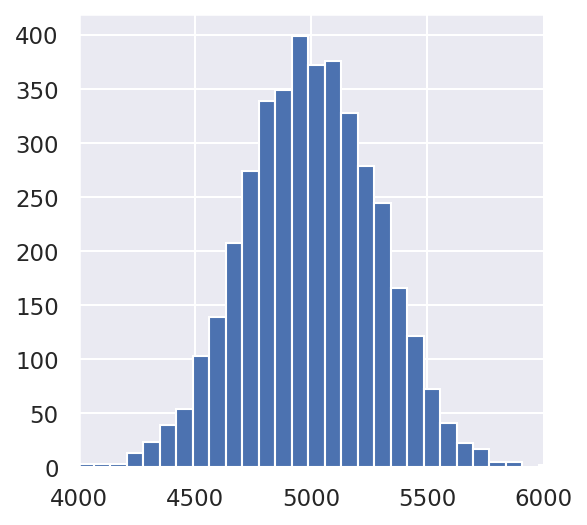

In [6]:
def var_estimate(f, pop, m=4000, n=100):
    """Estimate the variance of estimator f by the empirical variance.
    
    f: A function of a sample
    pop: An array representing the whole population
    m, n: Use m samples of size n to estimate the variance
    """
    estimates = []
    for j in range(m):
        sample = np.random.choice(pop, size=n, replace=False)
        estimates.append(f(sample))
    estimates = np.array(estimates)
    plt.hist(estimates, bins=30)
    plt.xlim(4000, 6000)
    return np.var(estimates)

var_estimate(np.mean, population)

In [7]:
83465.5906135476**0.5

288.9041201048327

19884.378867690735

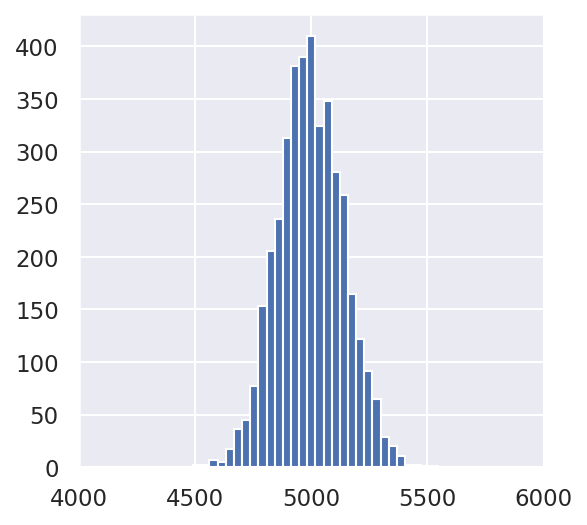

In [8]:
var_estimate(np.mean, population, n=400)

4264.277193892193

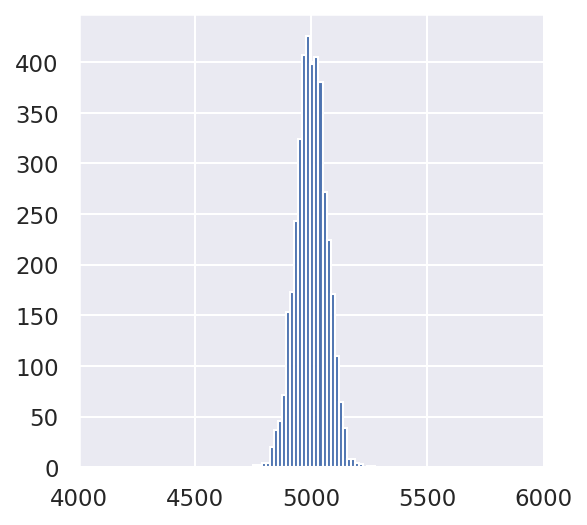

In [9]:
var_estimate(np.mean, population, n=1600)

This is not a new phenomenon. In Lecture 3, we saw that the variance of the sample mean decreases as our sample size increases.

If we know the variance of the sampling distribution and we know that the sampling distribution is approximately normal, then we know how far off a single estimate is likely to be. About 95% of estimates will be within 2 standard deviations of the mean, so for 95% of samples, the estimate will be off by the following (or less).

590.5010497482366

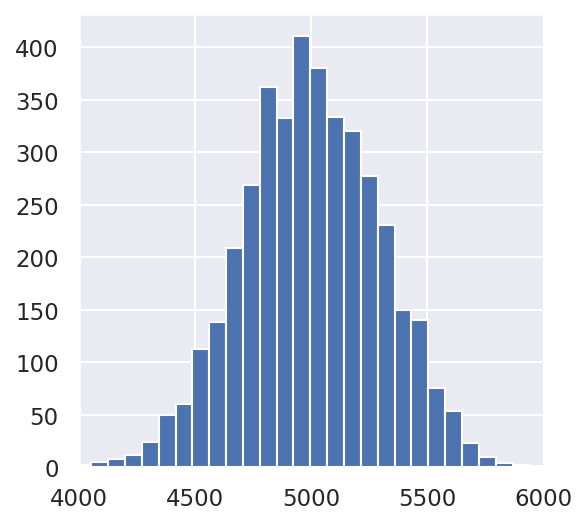

In [10]:
2 * np.sqrt(var_estimate(np.mean, population))

Unfortunately, estimating the variance required repeated sampling from the population.

### Bootstrap estimator for the variance of the sample mean

Instead, we can estimate the variance using bootstrap resampling.

92767.90456840598

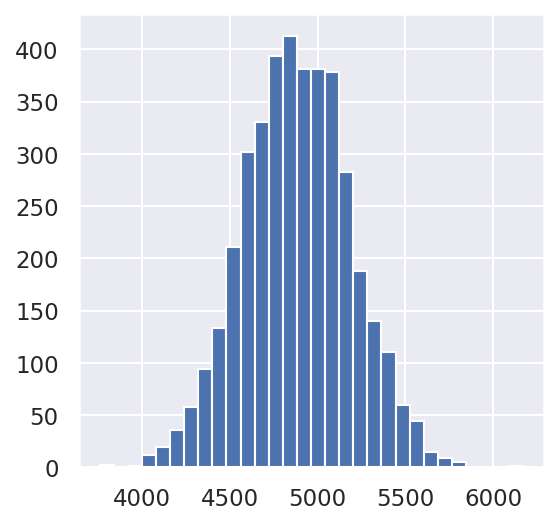

In [11]:
def bootstrap_var_estimate(f, sample, m=4000):
    """Estimate the variance of estimator f by the empirical variance.
    
    f: A function of a sample
    sample: An array representing a sample of size n
    m: Use m samples of size n to estimate the variance
    """
    estimates = []
    n = len(sample)
    for j in range(m):
        resample = np.random.choice(sample, size=n, replace=True)
        estimates.append(f(resample))
    estimates = np.array(estimates)
    plt.hist(estimates, bins=30)
    return np.mean((estimates - np.mean(estimates))**2) # same as np.var(estimates)

bootstrap_var_estimate(np.mean, sample_100)

In [12]:
np.mean(sample_100)

4891.23

21106.4840493027

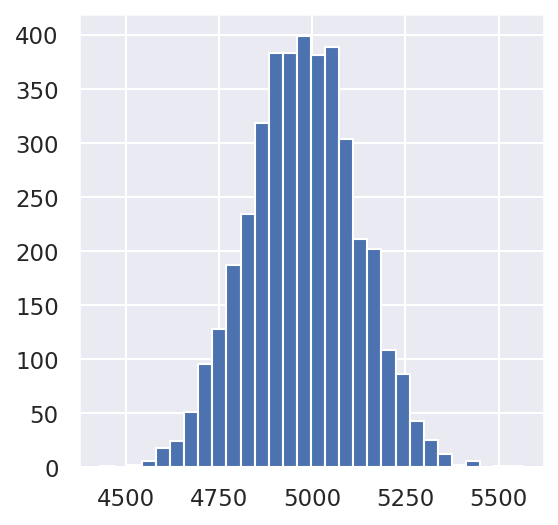

In [13]:
sample_400 = np.random.choice(population, 400, replace=False)
bootstrap_var_estimate(np.mean, sample_400)

5379.208413955419

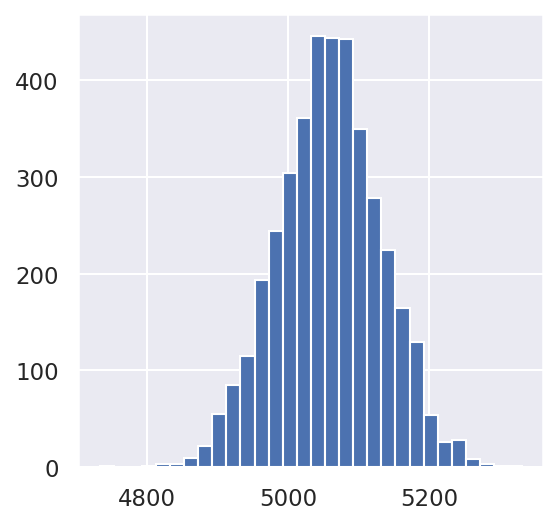

In [14]:
sample_1600 = np.random.choice(population, 1600, replace=False)
bootstrap_var_estimate(np.mean, sample_1600)

We can see that the estimated variance when bootstrapping our sample is close to the variance computed by directly sampling from the population. But, it's a good amount wrong each time.

### Bootstrap confidence interval

In [15]:
def ci(sample, estimator, confidence=95, m=1000):
    """Compute a confidence interval for an estimator.
    
    sample: A DataFrame or Series
    estimator: A function from a sample DataFrame to an estimate (number)
    """
    if isinstance(sample, np.ndarray):
        sample = pd.Series(sample)
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    estimates = np.array(estimates)
    slack = 100 - confidence
    lower = np.percentile(estimates, slack/2)
    upper = np.percentile(estimates, 100 - slack/2)
    return (lower, upper)

Here's one bootstrapped confidence interval for the sample mean.

In [16]:
ci(sample_100, np.mean)

(4316.2615000000005, 5457.73025)

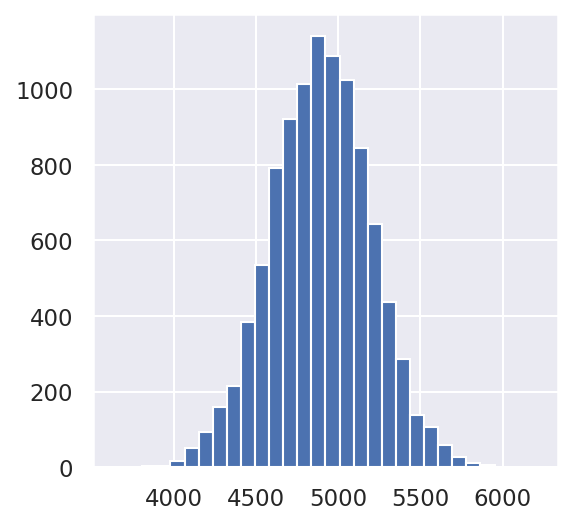

In [17]:
def bootstrap_dist(sample, estimator, m=10000):
    if isinstance(sample, np.ndarray):
        sample = pd.Series(sample)
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    plt.hist(estimates, bins=30)
    
bootstrap_dist(sample_100, np.mean)

To be crystal clear, the above histogram was computed by:
- resampling from our original sample `sample_100`, 10000 times
- each of those 10000 times, computing the sample mean
- calling `plt.hist` on the list of 10000 bootstrapped sample means

Let's create 100 95% confidence intervals for the sample mean. We'd expect roughly 95% of them to contain the true population parameter. In practice, we wouldn't be able to check (because if we knew the true population parameter, we wouldn't be doing any of this).

In [18]:
mean_ints = [ci(np.random.choice(population, 100), np.mean)
             for _ in tnrange(100)]

/tmp/ipykernel_1810/2581637515.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(100)]


  0%|          | 0/100 [00:00<?, ?it/s]

You will note, many of these intervals contain the true population parameter 5000, but some do not.

In [19]:
mean_ints

[(5042.2787499999995, 6128.70975),
 (4737.525250000001, 5813.98825),
 (4499.9980000000005, 5597.47825),
 (4451.8995, 5527.187999999999),
 (5038.9865, 6056.23975),
 (4263.074500000001, 5266.77625),
 (4496.621499999999, 5505.88575),
 (4262.69375, 5439.482),
 (3861.4925, 5063.2515),
 (4956.09775, 6022.171),
 (3615.53425, 4701.322749999999),
 (4442.1245, 5596.071000000001),
 (4498.735750000001, 5658.71825),
 (4507.4575, 5621.028249999999),
 (4439.231, 5620.148249999999),
 (4993.7125, 6170.85675),
 (4212.04625, 5249.291499999999),
 (4229.461249999999, 5331.68425),
 (5326.70025, 6348.1515),
 (4721.3775000000005, 5800.662),
 (4873.1272500000005, 6001.91225),
 (4229.7905, 5347.226250000001),
 (4256.326499999999, 5342.71525),
 (4578.864500000001, 5733.956749999999),
 (4619.047, 5568.8805),
 (4719.15775, 5736.46375),
 (4348.665, 5609.999),
 (4386.3282500000005, 5412.3904999999995),
 (4406.5830000000005, 5573.8727499999995),
 (4433.54475, 5468.29675),
 (4657.51925, 5717.335999999999),
 (4318.0487

Each time you run the above simulation, you may get a slightly different number printed below. The number printed below is the number of intervals from above that contain the true population parameter. It should be close to 95.

We also have visualized the left and right endpoints of each of the confidence intervals.
- If the left (blue) endpoint is greater than 5000 or the right (orange) endpoint is less than 5000, that interval does not contain the true population parameter.

91

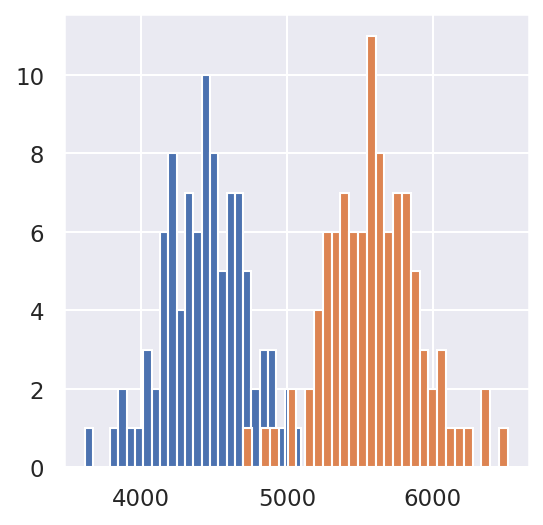

In [20]:
plt.hist([v[0] for v in mean_ints], bins=30);
plt.hist([v[1] for v in mean_ints], bins=30);
sum([v[0] <= 5000 <= v[1] for v in mean_ints])

### Bootstrap confidence intervals for other population parameters

#### Median

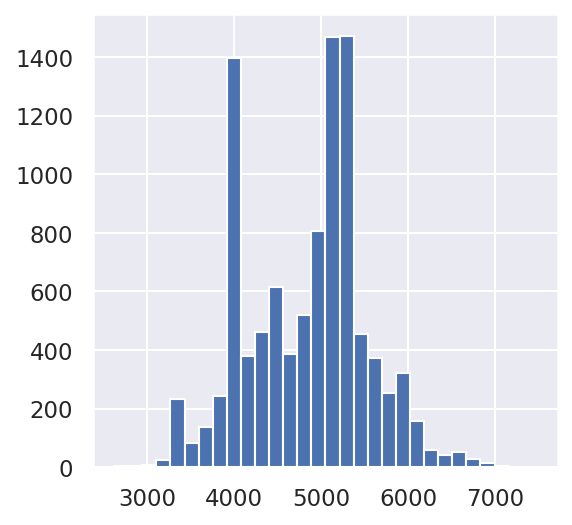

In [21]:
bootstrap_dist(sample_100, np.median)

In [22]:
ci(sample_100, np.median)

(3395.0, 6106.137499999999)

In [23]:
# True population median
np.median(population)

5000.0

#### Standard Deviation

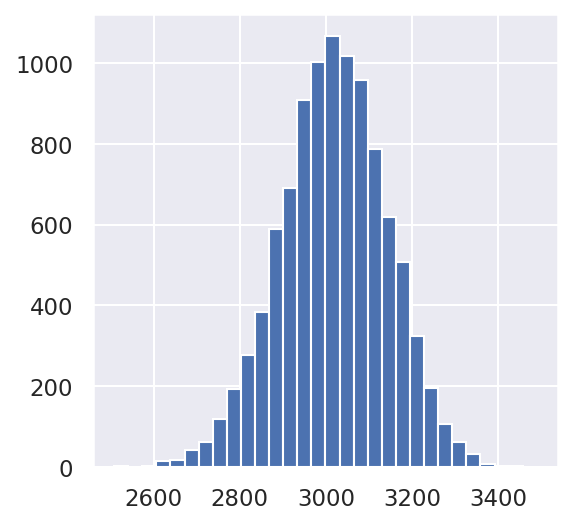

In [24]:
bootstrap_dist(sample_100, np.std)

In [25]:
ci(sample_100, np.std)

(2777.4790016886896, 3275.346070876512)

In [26]:
# True population standard deviation
np.std(population)

2887.0400066504103

#### 99th Percentile

In [27]:
p99 = lambda a: np.percentile(a, 99)
p99(population)

9900.0

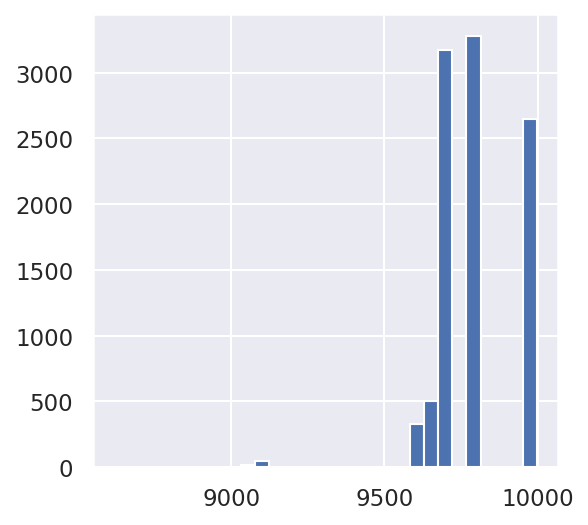

In [28]:
bootstrap_dist(sample_100, p99)

In [29]:
ci(sample_100, p99)

(9609.070000000002, 9998.0)

In [30]:
p99_ints = [ci(np.random.choice(population, 100), p99)
            for _ in tnrange(100)]

/tmp/ipykernel_1810/4008959745.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(100)]


  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
sum([v[0] <= p99(population) <= v[1] for v in p99_ints])

67

Extreme percentiles aren't estimated well with the bootstrap. Only 60-70 / 100 of our 95% confidence intervals contained the true population parameter.

## Estimating Parameters in Linear Regression

Let's revisit an old friend.

In [32]:
nba = pd.read_csv('nba18-19.csv')

In [33]:
nba

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,528,Tyler Zeller\zellety01,C,29,MEM,4,1,20.5,4.0,7.0,...,0.778,2.3,2.3,4.5,0.8,0.3,0.8,1.0,4.0,11.5
704,529,Ante Žižić\zizican01,C,22,CLE,59,25,18.3,3.1,5.6,...,0.705,1.8,3.6,5.4,0.9,0.2,0.4,1.0,1.9,7.8
705,530,Ivica Zubac\zubaciv01,C,21,TOT,59,37,17.6,3.6,6.4,...,0.802,1.9,4.2,6.1,1.1,0.2,0.9,1.2,2.3,8.9
706,530,Ivica Zubac\zubaciv01,C,21,LAL,33,12,15.6,3.4,5.8,...,0.864,1.6,3.3,4.9,0.8,0.1,0.8,1.0,2.2,8.5


This table provides aggregate statistics for each player throughout the 2018-19 NBA season.

Let's use `FG`, `FGA`, `FT%`, `3PA`, and `AST` to predict `PTS`. For reference:
- `FG` is the number of shots a player made.
- `FGA` is the number of shots a player took.
- `FT%` is the proportion of free throw shots a player took that they made.
- `3PA` is the number of three-point shots a player took.
- `AST` is the number of assists the player had.

In [34]:
nba_small = nba[['FG', 'FGA', 'FT%', '3PA', 'AST', 'PTS']].fillna(0)
nba_small

,FG,FGA,FT%,3PA,AST,PTS
0,1.8,5.1,0.923,4.1,0.6,5.3
1,0.4,1.8,0.700,1.5,0.8,1.7
2,1.1,3.2,0.778,2.2,1.9,3.2
3,6.0,10.1,0.500,0.0,1.6,13.9
4,3.4,5.9,0.735,0.2,2.2,8.9
...,...,...,...,...,...,...
703,4.0,7.0,0.778,0.0,0.8,11.5
704,3.1,5.6,0.705,0.0,0.9,7.8
705,3.6,6.4,0.802,0.0,1.1,8.9
706,3.4,5.8,0.864,0.0,0.8,8.5


Note that this is really just for the sake of example; the correlation between `FG` and `PTS` is so high that we in practice wouldn't need all of these other features.

In [35]:
reg = lm.LinearRegression()
reg.fit(nba_small.iloc[:,:-1], nba_small.iloc[:,-1])

LinearRegression()

The Multiple $R^2$ value is quite high:

In [36]:
reg.score(nba_small.iloc[:,:-1], nba_small.iloc[:,-1])

0.9886417979129902

Let's look at the coefficients, though:

In [37]:
nba_small.columns

Index(['FG', 'FGA', 'FT%', '3PA', 'AST', 'PTS'], dtype='object')

In [38]:
reg.coef_.astype(float)

array([2.44566707, 0.03633589, 0.50454007, 0.28367305, 0.04144433])

The coefficient on `FGA`, the number of shots a player takes, is very low. This means that `FGA` is not very useful in predicting `PTS`. That's strange – because we'd think that the number of shots a player takes would be very useful in such a case.

Let's look at a 95% confidence interval (created using the bootstrap percentile technique from above) for the coefficient on `FGA`.

In [39]:
def FGA_slope(t):
    reg = lm.LinearRegression().fit(t.iloc[:,:-1], t.iloc[:,-1])
    return reg.coef_[1]

ci(nba_small, FGA_slope)

(-0.06585682231822129, 0.14010320566346698)

We see 0 is in this interval. Hmmmm....

## Multicollinearity

The issue is that `FGA` is highly correlated with one of the other features in our design matrix.

In [40]:
nba_small.corr()

,FG,FGA,FT%,3PA,AST,PTS
FG,1.000000,0.973355,0.371598,0.600830,0.665761,0.990014
FGA,0.973355,1.000000,0.395902,0.725114,0.703093,0.980447
FT%,0.371598,0.395902,1.000000,0.377633,0.288057,0.401555
3PA,0.600830,0.725114,0.377633,1.000000,0.480880,0.666673
AST,0.665761,0.703093,0.288057,0.480880,1.000000,0.676022
PTS,0.990014,0.980447,0.401555,0.666673,0.676022,1.000000


The correlation between `FGA` and `FG` is very close to 1. This is a sign of multicollinearity, meaning that the individual coefficients have little meaning.

Let's look at the resulting model that comes from only using `FGA` as a feature.

In [41]:
simple_model = lm.LinearRegression()
simple_model.fit(nba_small[['FGA']].values.reshape(-1, 1), nba_small['PTS'])

LinearRegression()

We dropped all of those features, but the Multiple $R^2$ value is almost the same. The simpler, the better.

In [42]:
simple_model.score(nba_small[['FGA']].values.reshape(-1, 1), nba_small['PTS'])

0.9612756271235542

The coefficient on `FGA` in this model, of course, is positive.

In [43]:
simple_model.coef_

array([1.29982787])

In [44]:
def FGA_slope_simple_model(t):
    reg = lm.LinearRegression().fit(t[['FGA']].values.reshape(-1, 1), t['PTS'])
    return reg.coef_[0]

ci(nba_small, FGA_slope_simple_model)

(1.2739728618051318, 1.3267754085445898)

0 is not in this interval, so we know that the slope for `FGA` in the linear model with `PTS` is significantly different than 0.